In [1]:
%load_ext autoreload
# %reload_ext autoreload

In [2]:
import os
import pandas as pd
import numpy as np
from pycaret.regression import *
from pathlib import Path
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

In [3]:
# from pycaret.utils import version
# version()

In [4]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import os

current_dir = os.getcwd()
print("Current working directory:", current_dir)


PATH = "/Users/matsalexander/Desktop/Forest Gump/"
# Estimate
X_train_estimated_a: pd.DataFrame = pd.read_parquet(
    PATH + 'A/X_train_estimated.parquet')
X_train_estimated_b: pd.DataFrame = pd.read_parquet(
    PATH + "B/X_train_estimated.parquet")
X_train_estimated_c: pd.DataFrame = pd.read_parquet(
    PATH + "C/X_train_estimated.parquet")

# Test estimates
X_test_estimated_a: pd.DataFrame = pd.read_parquet(
    PATH + "A/X_test_estimated.parquet")
X_test_estimated_b: pd.DataFrame = pd.read_parquet(
    PATH + "B/X_test_estimated.parquet")
X_test_estimated_c: pd.DataFrame = pd.read_parquet(
    PATH + "C/X_test_estimated.parquet")

# Observations
X_train_observed_a: pd.DataFrame = pd.read_parquet(
    PATH + "A/X_train_observed.parquet")
X_train_observed_b: pd.DataFrame = pd.read_parquet(
    PATH + "B/X_train_observed.parquet")
X_train_observed_c: pd.DataFrame = pd.read_parquet(
    PATH + "C/X_train_observed.parquet")

# Targets
Y_train_observed_a: pd.DataFrame = pd.read_parquet(
    PATH + "A/train_targets.parquet")
Y_train_observed_b: pd.DataFrame = pd.read_parquet(
    PATH + "B/train_targets.parquet")
Y_train_observed_c: pd.DataFrame = pd.read_parquet(
    PATH + "C/train_targets.parquet")

test_df_example = pd.read_csv(PATH + "test.csv")

best_submission: pd.DataFrame = pd.read_csv(
    PATH + "mikael/submissions/fourth_submission.csv")

optins = {
    "randomize": False,
    "consecutive_threshold": 6,
    "normalize": False,
    "group_by_hour": True,
    "unzip_date_feature": True,
}

# make a options class with the options as attributes


class Options:
    randomize = False
    consecutive_threshold = 6
    normalize = False
    group_by_hour = True
    unzip_date_feature = True

    def __init__(self, randomize=False, consecutive_threshold=6, normalize=False, group_by_hour=True, unzip_date_feature=True) -> None:
        self.randomize = randomize
        self.consecutive_threshold = consecutive_threshold
        self.normalize = normalize
        self.group_by_hour = group_by_hour
        self.unzip_date_feature = unzip_date_feature


class Pipeline:

    def __init__(self):
        pass

    def get_combined_data(self, test_data=False):
        locations = ["A", "B", "C"]
        dfs = []
        for index, location in enumerate(locations):
            if test_data:
                dfs.append(self.get_test_data(location))
            else:
                dfs.append(self.get_data(location))

            dfs[index] = self.onehot_location(dfs[index], location)
        df = pd.concat(dfs).reset_index(drop=True)

        if test_data:
            return df
        return df[[c for c in df if c not in ['pv_measurement']] +  # pv measurement is the target and is at the end columns
                  ['pv_measurement']]

    def get_data(self, location: str, keeptime=False) -> pd.DataFrame:
        train, targets = self.get_training_data_by_location(location)
        return self.handle_data(train, targets, keeptime=keeptime)

    def get_test_data(self, location: str) -> pd.DataFrame:
        test_data = self.get_test_data_by_location(location)
        return self.handle_data(test_data)

    def handle_data(self, df, targets=pd.DataFrame(), keeptime=False):
        df["date_calc"] = pd.to_datetime(df["date_calc"])
        df["date_forecast"] = pd.to_datetime(df["date_forecast"])

        # df = self.add_time_since_calucation(df)
        df = self.onehot_estimated(df)
        df = self.unzip_date_feature(df)
        df = self.grouped_by_hour(df)

        df["time"] = df["date_forecast"]
        df.drop(["date_forecast"], axis=1, inplace=True)

        if not targets.empty:
            df = self.merge_train_target(df, targets)

        df.drop(columns=["time"], axis=1, inplace=True)

        df = self.absolute_values(df)
        return df

    # –––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– helper funciton ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

    def get_training_data_by_location(self, location):
        if location == "A":
            X_train_observed_x = X_train_observed_a
            X_train_estimated_x = X_train_estimated_a
            Y_train_x = Y_train_observed_a
        elif location == "B":
            X_train_observed_x = X_train_observed_b
            X_train_estimated_x = X_train_estimated_b
            Y_train_x = Y_train_observed_b
        elif location == "C":
            X_train_observed_x = X_train_observed_c
            X_train_estimated_x = X_train_estimated_c
            Y_train_x = Y_train_observed_c
        else:
            raise Exception("location must be A, B or C")
        train = pd.concat(
            [X_train_observed_x, X_train_estimated_x]).reset_index(drop=True)
        return train, Y_train_x

    def get_test_data_by_location(self, location: str,  normalize=False) -> pd.DataFrame:
        if location == "A":
            df = X_test_estimated_a
        elif location == "B":
            df = X_test_estimated_b
        elif location == "C":
            df = X_test_estimated_c
        else:
            raise Exception("location must be A, B or C")
        return df.copy()

    def unzip_date_feature(self, df: pd.DataFrame, date_column: str = "date_forecast"):
        df[date_column] = pd.to_datetime(df[date_column])
        df["day_of_year"] = df["date_forecast"].dt.day_of_year
        df["hour"] = df["date_forecast"].dt.hour
        # df["month"] = df["date_forecast"].dt.month
        return df

    def add_time_since_calucation(self, df):  # denne er ikke så dum.
        df["date_calc"] = pd.to_datetime(df["date_calc"])
        df["calculated_ago"] = (
            df["date_forecast"] - df["date_calc"]).dt.total_seconds()
        df["calculated_ago"] = df["calculated_ago"].fillna(
            0) / 60/30
        return df

    def onehot_estimated(self, df):
        df["estimated"] = 0  # Initialize both columns to 0
        df["observed"] = 0
        estimated_mask = df["date_calc"].notna()
        df.loc[estimated_mask, "estimated"] = 1
        df.loc[~estimated_mask, "observed"] = 1
        return df

    def onehot_location(self, df, location):
        if location == "A":
            df["A"], df["B"], df["C"] = 1, 0, 0
        elif location == "B":
            df["A"], df["B"], df["C"] = 0, 1, 0
        elif location == "C":
            df["A"], df["B"], df["C"] = 0, 0, 1
        return df

    def grouped_by_hour(self, df: pd.DataFrame, date_column: str = "date_forecast"):
        df = df.groupby(pd.Grouper(key=date_column, freq="1H")
                        ).mean(numeric_only=True)
        all_nan_mask = df.isnull().all(axis=1)
        df = df[~all_nan_mask]
        return df.reset_index()

    def merge_train_target(self, x, y):
        # henning får med alle pv measurments selv om han merger på inner time. Fordi resample fyller nan rows for alle timer som ikke er i datasettet.
        merged = pd.merge(x, y, on="time", how="right")
        mask = merged["pv_measurement"].notna()
        merged = merged.loc[mask].reset_index(drop=True)
        return merged

    def absolute_values(self, df: pd.DataFrame):
        columns = list(df.columns)
        df[columns] = df[columns].abs()
        df = df.replace(-0.0, 0.0)
        return df

    def lag_features_by_1_hour(df, columns_to_lag):
        lag_columns = [c for c in df.columns if "_1h:" in c]
        df[lag_columns] = df[lag_columns].shift(1)
        return df

    def remove_consecutive_measurments_new(self, df: pd.DataFrame, consecutive_threshold=3, consecutive_threshold_zero=12, return_removed=False):
        if consecutive_threshold < 2:
            return df

        column_to_check = 'pv_measurement'

        mask = (df[column_to_check] != df[column_to_check].shift(1)).cumsum()
        df['consecutive_group'] = df.groupby(
            mask).transform('count')[column_to_check]

        df["is_first_in_consecutive_group"] = False
        df['is_first_in_consecutive_group'] = df['consecutive_group'] != df['consecutive_group'].shift(
            1)

        # masks to remove rows
        mask_non_zero = (df['consecutive_group'] >= consecutive_threshold) & (
            df["pv_measurement"] > 0) & (df["is_first_in_consecutive_group"] == False)  # or df["direct_rad:W"] == 0)

        mask_zero = (df['consecutive_group'] >= consecutive_threshold_zero) & (
            df["pv_measurement"] == 0) & (df["is_first_in_consecutive_group"] == False)

        mask = mask_non_zero | mask_zero

        if return_removed:
            return df[mask]

        df = df.loc[~mask]

        df = df.drop(columns=["consecutive_group",
                     "is_first_in_consecutive_group"])

        return df.reset_index(drop=True)

    def remove_consecutive_measurments_new_new(self, df: pd.DataFrame, consecutive_threshold=3, consecutive_threshold_zero=12, consecutive_threshold_zero_no_rad=20, return_removed=False):
        if consecutive_threshold < 2:
            return df

        column_to_check = 'pv_measurement'

        mask = (df[column_to_check] != df[column_to_check].shift(1)).cumsum()
        df['consecutive_group'] = df.groupby(
            mask).transform('count')[column_to_check]

        df["is_first_in_consecutive_group"] = False
        df['is_first_in_consecutive_group'] = df['consecutive_group'] != df['consecutive_group'].shift(
            1)

        # masks to remove rows
        mask_non_zero = (df['consecutive_group'] >= consecutive_threshold) & (
            df["pv_measurement"] > 0) & (df["is_first_in_consecutive_group"] == False)  # or df["direct_rad:W"] == 0)

        tol = 10
        mask_zero = (df['consecutive_group'] >= consecutive_threshold_zero) & (
            df["pv_measurement"] == 0) & (df["direct_rad:W"] > tol)

        mask_zero_no_rad = (df['consecutive_group'] >= consecutive_threshold_zero_no_rad) & (
            df["pv_measurement"] == 0) & (df["direct_rad:W"] < tol)
        mask = mask_non_zero | mask_zero | mask_zero_no_rad

        if return_removed:
            return df[mask]

        df = df.loc[~mask]

        df = df.drop(columns=["consecutive_group",
                     "is_first_in_consecutive_group"])

        return df.reset_index(drop=True)

    def compare_mae(self, df: pd.DataFrame):
        best_submission: pd.DataFrame = pd.read_csv(
            PATH+"mats/submissions/gluon_3_remove_consecutive_measurements_66.csv")
        best_submission = best_submission[["prediction"]]

        if best_submission.shape != df.shape:
            print("best_submission", best_submission.shape)
            print("df", df.shape)
            raise Exception("Dataframe shape must be the same")

        return mean_absolute_error(
            best_submission["prediction"], df["prediction"])

    def split_train_tune(self, df: pd.DataFrame):
        df = df.copy()
        df_estimated = df.loc[df["estimated"] == 1]
        df_observed = df.loc[df["estimated"] == 0]

        num_rows = len(df_estimated)
        middle_index = num_rows // 2

        df_estimated.sample(frac=1, random_state=42)
        train_estimated = df_estimated.iloc[:middle_index]
        tune = df_estimated.iloc[middle_index:]

        train = pd.concat([df_observed, train_estimated])
        return train, tune

    def drop_columns(self, df: pd.DataFrame):
        drop = [
            # wind speed vector u, available up to 20000 m, from 1000 hPa to 10 hPa and on flight levels FL10-FL900[m/s] does not make sens at surfece level
            "wind_speed_w_1000hPa:ms",
            "wind_speed_u_10m:ms",  # same as above
            "wind_speed_v_10m:ms",  # same as above
            # "snow_drift:idx",
            # "snow_density:kgm3",
            # "snow_melt_10min:mm",  # veldig få verdier
        ]
        shared_columns = list(set(df.columns) & set(drop))
        df = df.drop(columns=shared_columns)
        return df

    def drop_columns_new(self, df: pd.DataFrame):
        drop = [
            # wind speed vector u, available up to 20000 m, from 1000 hPa to 10 hPa and on flight levels FL10-FL900[m/s] does not make sens at surfece level
            "wind_speed_w_1000hPa:ms",
            "wind_speed_u_10m:ms",  # same as above
            "wind_speed_v_10m:ms",  # same as above
            "snow_drift:idx",
            "snow_density:kgm3",
            # "snow_melt_10min:mm",  # veldig få verdier
        ]
        shared_columns = list(set(df.columns) & set(drop))
        df = df.drop(columns=shared_columns)
        return df

    def find_min_max_date_in_test(self) -> list:
        locations = ["A", "B", "C"]
        dates = []
        for loc in locations:
            df = self.get_test_data_by_location(loc)
            df["date_forecast"] = pd.to_datetime(df["date_forecast"])
            dates.append((df["date_forecast"].min(),
                         df["date_forecast"].max()))
        return dates

    def split_train_summer_2021(self, df: pd.DataFrame):
        dates = self.find_min_max_date_in_test()
        # set the dates to the summer of 2021
        dates = [(date[0].replace(year=2021), date[1].replace(year=2021))
                 for date in dates]

        summer2021 = df[(df["date_forecast"] >= dates[0][0]) & (
            df["date_forecast"] <= dates[0][1])]

        train = df[~df.index.isin(summer2021.index)]
        return train, summer2021

    def post_processing(self, df: pd.DataFrame, prediction_column: str = "prediction_label"):
        df = df[[prediction_column]].rename(
            columns={prediction_column: "prediction"}).reset_index(drop=True).rename_axis(index="id")

        df["prediction"] = df["prediction"].clip(lower=0)
        return df


pipin = Pipeline()

Current working directory: /Users/matsalexander/Desktop/Forest Gump/final_submission/mats_explore_to_merge


In [5]:
df_0 = pipin.get_combined_data()
df_0 = pipin.remove_consecutive_measurments_new(df_0, consecutive_threshold=3,consecutive_threshold_zero=3 )
# //get_combined_datasets(consecutive_threshold=3)

In [6]:
df = df_0.copy()
print(df.shape)
df.head(15)

(43858, 53)


,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,observed,day_of_year,hour,A,B,C,pv_measurement
0,7.700000,1.22825,1728.949951,0.000000e+00,0.000000,1728.949951,0.0,280.299988,0.000000,0.000000,0.000000,0.000000e+00,99.074997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.299988,0.0,0.0,993.750000,999.775024,0.0,0.000,71.674995,1005.799988,NaN,0.0,0.0,0.0,0.175,348.036743,3.774250,0.000,286.225006,100.000000,40386.476562,3.600,3.575,0.500,0.0,0.0,1.0,153.0,22.0,1,0,0,0.00
1,8.950000,1.21800,1003.500000,3.246815e+04,23.100000,1003.500000,0.0,282.500000,11.975000,22068.949219,0.150000,2.829750e+02,84.875000,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1003.099976,0.0,0.0,990.550049,996.500000,0.0,0.100,79.925003,1002.500000,NaN,0.0,0.0,0.0,0.250,41.997501,3.051250,0.000,286.450012,99.224998,11634.799805,2.550,2.350,0.925,0.0,0.0,1.0,154.0,2.0,1,0,0,19.36
2,9.250000,1.21650,809.375000,1.794991e+05,84.375000,809.375000,0.0,283.049988,45.125000,102788.046875,6.300000,1.162755e+04,65.025002,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1002.349976,0.0,0.0,989.750000,995.700012,0.0,0.000,82.849998,1001.674988,NaN,0.0,0.0,0.0,0.100,55.041748,8.071000,0.000,286.475006,94.800003,29848.199219,2.300,2.200,0.800,0.0,0.0,1.0,154.0,3.0,1,0,0,251.02
3,9.525000,1.21300,757.775024,4.781178e+05,186.649994,757.775024,0.0,283.524994,89.525002,242438.000000,43.724998,9.007338e+04,77.550003,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1001.825012,0.0,0.0,989.250000,995.200012,0.0,0.000,82.275002,1001.174988,NaN,0.0,0.0,0.0,0.000,67.898003,13.956500,0.000,286.825012,95.099998,35980.148438,2.325,2.200,0.750,0.0,0.0,1.0,154.0,4.0,1,0,0,263.78
4,9.700000,1.20750,705.650024,8.926679e+05,311.525024,705.650024,0.0,283.799988,139.000000,411381.906250,53.099998,1.742545e+05,85.050003,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1001.200012,0.0,0.0,988.700012,994.599976,0.0,0.000,78.699997,1000.500000,NaN,0.0,0.0,0.0,0.000,80.821251,20.406250,0.000,287.325012,97.150002,37874.523438,2.225,2.000,0.950,0.0,0.0,1.0,154.0,5.0,1,0,0,522.72
5,9.550000,1.20500,669.650024,1.357902e+06,442.750000,669.650024,0.0,283.600006,167.100006,550960.562500,33.825001,1.564732e+05,96.750000,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1000.750000,0.0,0.0,988.275024,994.200012,0.0,0.050,75.099998,1000.150024,NaN,0.0,0.0,0.0,0.125,94.178497,27.096001,0.000,287.450012,99.199997,25470.250000,2.350,1.750,1.525,0.0,0.0,1.0,154.0,6.0,1,0,0,904.42
6,9.450000,1.20500,662.224976,1.821739e+06,567.299988,662.224976,0.0,283.524994,217.699997,692633.125000,17.600000,9.265122e+04,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1000.849976,0.0,0.0,988.349976,994.250000,0.0,0.150,74.199997,1000.174988,NaN,0.0,0.0,0.0,0.425,108.438499,33.660751,0.000,287.325012,100.000000,2655.699951,2.700,1.175,2.425,0.0,0.0,1.0,154.0,7.0,1,0,0,1238.82
7,9.850000,1.20250,654.424988,2.242189e+06,674.700012,654.424988,0.0,284.149994,215.625000,779998.437500,13.075000,5.523405e+04,99.900002,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1000.599976,0.0,0.0,988.049988,993.925049,0.0,0.175,76.474998,999.849976,NaN,0.0,0.0,0.0,0.500,124.139496,39.661999,0.000,287.575012,100.000000,2567.725098,2.525,0.875,2.375,0.0,0.0,1.0,154.0,8.0,1,0,0,2189.88
8,10.075001,1.19850,997.600037,2.585010e+06,756.549988,997.600037,0.0,284.500000,265.575012,866128.562500,59.924999,1.313954e+05,

In [7]:
# s = setup(df_transformed, target="pv_measurement", normalize=False, categorical_features=categorical_features, experiment_name="pv_power_mw", ignore_features=ignore_features, index=False)
s = setup(df, target="pv_measurement", normalize=False, experiment_name="pv_power_mw",  index=False, fold_shuffle=True)
# s = setup(df, target="pv_measurement", normalize=False, categorical_features=categorical_features, experiment_name="pv_power_mw", ignore_features=ignore_features, index=False, fold_shuffle=True, feature_selection=True, feature_selection_estimator="et", n_features_to_select=30)
# s = setup(df, target="pv_measurement", normalize=False, categorical_features=categorical_features, experiment_name="pv_power_mw", ignore_features=ignore_features, index=False, imputation_type="iterative", feature_selection="classic", feature_selection_estimator="et", remove_multicollinearity=True, remove_outliers = True, low_variance_threshold = 0.1,)
# s = setup(df, target="pv_measurement", imputation_type="iterative", feature_selection="classic", feature_selection_estimator="et", remove_multicollinearity=True, remove_outliers = True, low_variance_threshold = 0.1,  normalize=False, categorical_features=categorical_features, experiment_name="pv_power_mw", ignore_features=ignore_features, index=False,)

,Description,Value
0,Session id,1715
1,Target,pv_measurement
2,Target type,Regression
3,Original data shape,"(43858, 53)"
4,Transformed data shape,"(43858, 53)"
5,Transformed train set shape,"(30700, 53)"
6,Transformed test set shape,"(13158, 53)"
7,Numeric features,52
8,Rows with missing values,98.7%
9,Preprocess,True


In [8]:
preprocessed_data = s.dataset_transformed
preprocessed_data
print(preprocessed_data.shape)
# print (preprocessed_data.columns)
preprocessed_data.tail(20)

(43858, 53)


,absolute_humidity_2mgm3,air_density_2mkgm3,ceiling_height_aglm,clear_sky_energy_1hJ,clear_sky_radW,cloud_base_aglm,dew_or_rimeidx,dew_point_2mK,diffuse_radW,diffuse_rad_1hJ,direct_radW,direct_rad_1hJ,effective_cloud_coverp,elevationm,fresh_snow_12hcm,fresh_snow_1hcm,fresh_snow_24hcm,fresh_snow_3hcm,fresh_snow_6hcm,is_dayidx,is_in_shadowidx,msl_pressurehPa,precip_5minmm,precip_type_5minidx,pressure_100mhPa,pressure_50mhPa,prob_rimep,rain_waterkgm2,relative_humidity_1000hPap,sfc_pressurehPa,snow_densitykgm3,snow_depthcm,snow_driftidx,snow_melt_10minmm,snow_waterkgm2,sun_azimuthd,sun_elevationd,super_cooled_liquid_waterkgm2,t_1000hPaK,total_cloud_coverp,visibilitym,wind_speed_10mms,wind_speed_u_10mms,wind_speed_v_10mms,wind_speed_w_1000hPams,estimated,observed,day_of_year,hour,A,B,C,pv_measurement
43838,7.100,1.22200,7870.399902,7.877881e+05,282.149994,5532.725098,0.0,279.100006,77.574997,264222.093750,191.324997,4.953902e+05,44.849998,7.0,0.00,0.0,0.000,0.0,0.000,1.00,0.00,1000.500000,0.0000,0.00,987.750000,993.724976,0.0,0.00,70.675003,999.724976,250.0,0.0,0.0,0.0,0.000,81.499748,18.856251,0.000,283.524994,87.375000,40138.675781,3.150,3.125,0.450,0.000,0.0,1.0,143.0,5.0,0.0,1.0,0.0,225.112503
43839,8.300,1.23425,3108.988281,6.054250e+02,2.150000,9581.299805,0.0,281.375000,1.350000,2409.800049,0.000000,0.000000e+00,12.625000,6.0,0.00,0.0,0.000,0.0,0.000,0.25,1.00,1012.500000,0.0000,0.00,999.849976,1005.875000,0.0,0.00,71.949997,1011.950012,250.0,0.0,0.0,0.0,0.000,94.768501,1.295000,0.000,285.500000,25.250000,45638.476562,2.325,2.300,0.150,0.000,0.0,1.0,275.0,5.0,1.0,0.0,0.0,45.540001
43840,4.100,1.27275,2276.225098,8.556409e+05,279.924988,1872.675049,0.0,271.100006,71.900002,203866.375000,0.625000,1.121700e+03,99.900002,6.0,0.00,0.0,0.000,0.0,0.000,1.00,0.00,1019.875000,0.0050,0.25,1006.750000,1012.950012,0.0,0.00,44.924999,1019.224976,250.0,0.0,0.0,0.0,0.075,146.388245,18.206001,0.125,278.024994,100.000000,54718.648438,2.800,1.250,2.475,0.000,0.0,1.0,69.0,9.0,1.0,0.0,0.0,1542.859985
43841,9.450,1.22925,5526.549805,3.894048e+05,63.424999,590.099976,0.0,283.399994,29.100000,172275.250000,8.600000,7.059865e+04,84.150002,6.0,0.00,0.0,0.000,0.0,0.000,1.00,0.00,1015.625000,0.0000,0.00,1002.849976,1008.849976,0.0,0.00,80.949997,1014.924988,250.0,0.0,0.0,0.0,0.000,305.278748,6.647000,0.075,285.175018,94.275002,26253.300781,2.925,2.650,1.275,0.000,0.0,1.0,199.0,19.0,1.0,0.0,0.0,78.760002
43842,8.750,1.19650,8191.299805,2.945132e+06,804.724976,8019.200195,0.0,282.774994,161.699997,609677.187500,505.600006,1.804198e+06,30.049999,24.0,0.00,0.0,0.000,0.0,0.000,1.00,0.00,1024.050049,0.0000,0.00,1008.549988,1014.450012,0.0,0.00,51.075001,1020.349976,250.0,0.0,0.0,0.0,0.000,202.227005,47.676250,0.000,291.075012,57.599998,51580.398438,1.950,1.225,1.500,0.000,0.0,1.0,156.0,12.0,0.0,0.0,1.0,803.599976
43843,12.425,1.18075,3108.988281,2.857203e+06,816.625000,3298.850098,0.0,288.200012,88.000000,308434.937500,634.700012,2.223421e+06,0.550000,7.0,0.00,0.0,0.000,0.0,0.000,1.00,0.00,1017.650024,0.0000,0.00,1005.200012,1010.950012,0.0,0.00,53.750000,1016.849976,250.0,0.0,0.0,0.0,0.000,159.796997,48.692749,0.000,295.950012,0.550000,51349.476562,2.150,0.775,2.000,0.000,0.0,1.0,178.0,10.0,0.0,1.0,0.0,715.875000
43844,15.050,1.16400,2358.800049,1.109371e+06,242.899994,2358.800049,0.0,291.299988,64.474998,273712.187500,120.849998,5.645444e+05,29.475000,6.0,0.00,0.0,0.000,0.0,0.000,1.00,0.00,1010.349976,0.0000,0.00,997.974976,1003.724976,0.0,0.00,55.200001,1009.450012,250.0,0.0,0.0,0.0,0.000,278.470490,16.933001,0.000,299.200012,33.875000,52791.726562,3.150,2.800,1.400,0.000,0.0,1.0,210.0,17.0,1.0,0.0,0.0,805.419983
43845,6.550,1.22800,3108.988281,2.352784e+06,658.974976,2291.050049,0.0,278.024994,145.000000,531143.375000,363.475006,1.303802e+06,44.049999,7.0,0.00,0.0,0.000,0.0,0.000,1.00,0.00,1011.650024,0.0000,0.00,998.849976,1004.849976,0.0,0.00,49.174999,1010.900024,250.0,0.0,0.0,0.0,0.000,181.063248,37.999748,0.000,284.975006,44.049999,40594.226562,1.4

In [9]:
modeller = models()
modell_navn = pd.DataFrame(modeller)
# modell_navn = modell_navn["ID"]
navn = list(modell_navn.index)
navn

['lr',
 'lasso',
 'ridge',
 'en',
 'lar',
 'llar',
 'omp',
 'br',
 'ard',
 'par',
 'ransac',
 'tr',
 'huber',
 'kr',
 'svm',
 'knn',
 'dt',
 'rf',
 'et',
 'ada',
 'gbr',
 'mlp',
 'xgboost',
 'lightgbm',
 'dummy']

In [10]:
top3 = compare_models(n_select=3, sort='MAE')
# lightgmb = create_model('lightgbm', sort='MAE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,168.0388,134143.4382,366.1099,0.8738,0.7183,1.9449,1.9110
rf,Random Forest Regressor,171.7623,140074.6236,374.1524,0.8682,0.7260,3.7921,5.3720
lightgbm,Light Gradient Boosting Machine,171.9184,131885.7478,362.9757,0.8759,1.0030,6.2696,0.5210
xgboost,Extreme Gradient Boosting,176.2997,131330.1656,362.2492,0.8765,1.2058,3.1099,0.1140
gbr,Gradient Boosting Regressor,202.8603,159148.7558,398.7659,0.8503,1.4681,6.0512,1.9210
dt,Decision Tree Regressor,233.9472,280689.5932,529.5366,0.7360,0.9064,1.5459,0.1090
ada,AdaBoost Regressor,289.7024,236166.6636,485.7023,0.7780,1.9041,22.5244,0.4950
huber,Huber Regressor,438.8240,917408.6066,957.6173,0.1377,1.3795,3.7204,0.1180
ridge,Ridge Regression,449.6801,380895.8188,617.1140,0.6417,2.3906,114.7524,0.0230
en,Elastic Net,473.0169,479573.4688,692.4287,0.5490,2.2547,50.6290,0.1090


<h1> Model evaluation </h1>

<p>
    We see that the most important feature is the location. Since we are making one modell with all 3 locations.
<p>

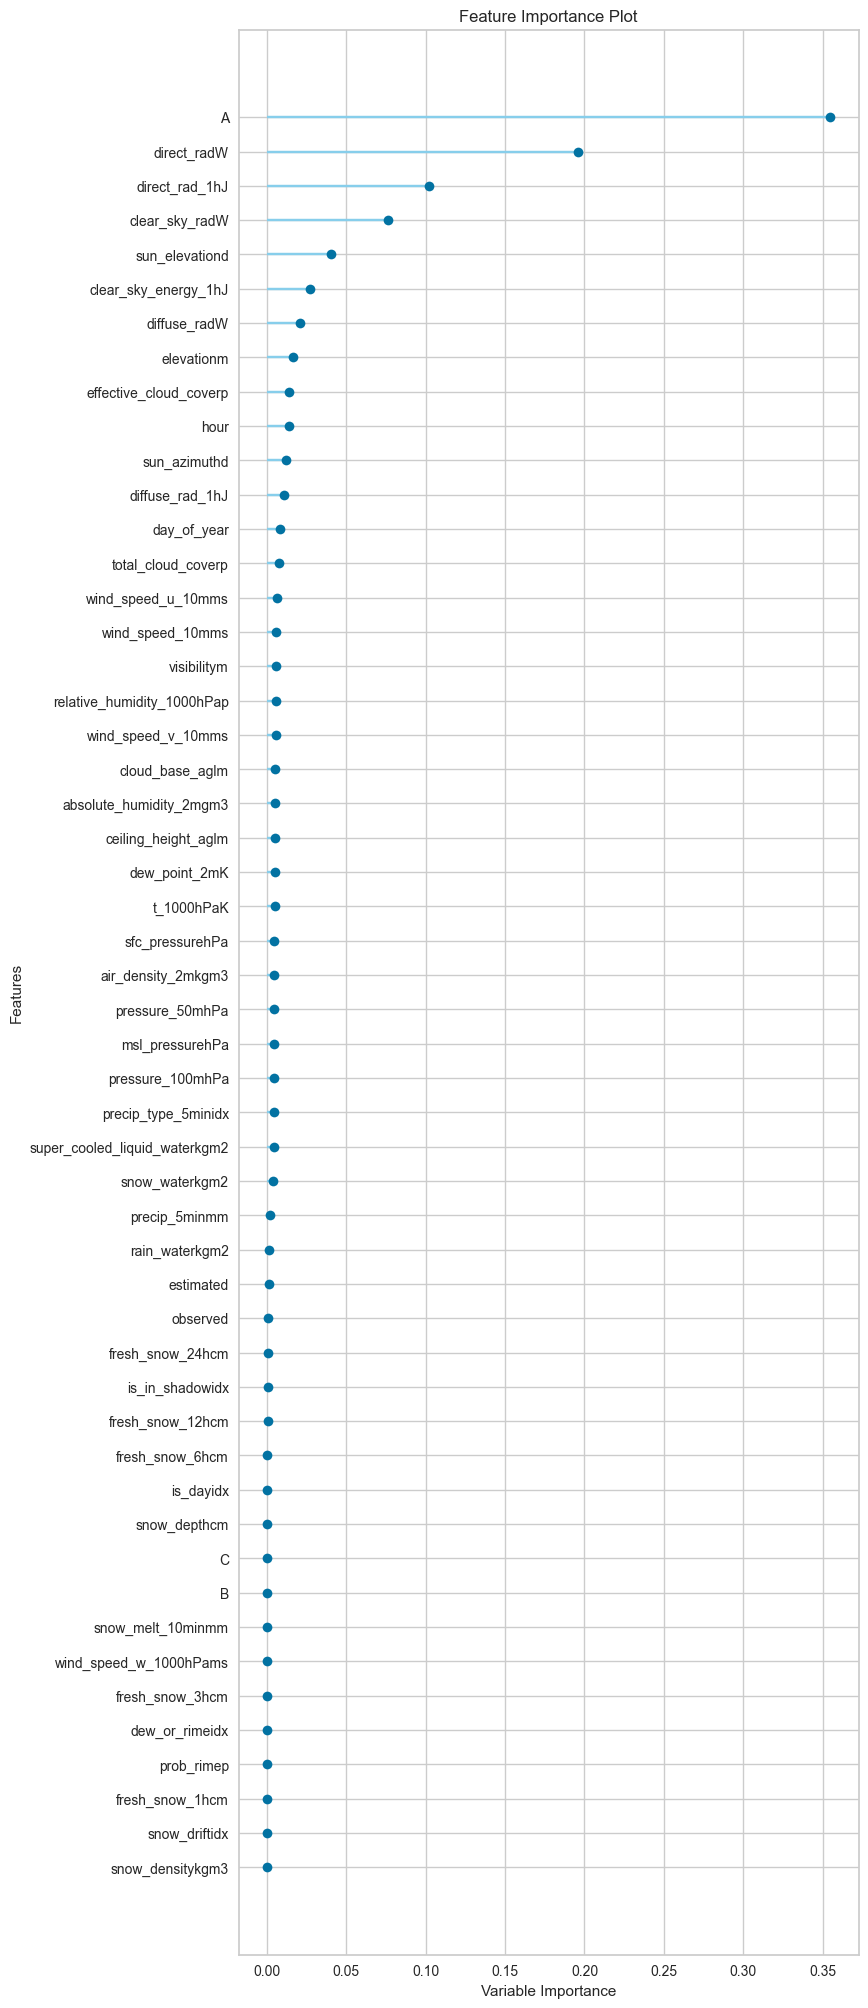

In [11]:
plot_model(top3[0], plot="feature_all")
# plot_model(gump, plot="feature_all")

In [12]:
test_data = pipin.get_combined_data(test_data=True)

In [13]:
tdf = pipin.get_test_data("A")
tdf

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,observed,day_of_year,hour
0,4.325,1.28675,912.700012,0.000000,0.000000,1061.550049,0.0,271.650024,0.000000,0.000000,...,74.949997,29907.500000,3.950,2.100,3.350,0.0,1.0,0.0,121.0,0.0
1,4.275,1.28600,1482.099976,0.000000,0.000000,1075.100098,0.0,271.450012,0.000000,0.000000,...,77.474998,29519.074219,3.825,1.925,3.300,0.0,1.0,0.0,121.0,1.0
2,4.150,1.28375,1791.300049,0.000000,0.000000,1200.400024,0.0,271.049988,0.000000,0.000000,...,88.099998,31009.125000,3.650,1.750,3.200,0.0,1.0,0.0,121.0,2.0
3,4.025,1.28200,2312.875000,10124.424805,11.675000,1179.849976,0.0,270.649994,9.375000,16845.226562,...,68.599998,34552.500000,3.500,1.450,3.150,0.0,1.0,0.0,121.0,3.0
4,3.900,1.28100,2198.299805,141748.593750,76.875000,920.049988,0.0,270.375000,47.400002,102209.703125,...,66.300003,35483.875000,3.325,1.300,3.050,0.0,1.0,0.0,121.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,8.350,1.19725,3638.899902,477093.187500,85.099998,2013.750000,0.0,281.575012,33.625000,168774.546875,...,86.150002,44056.375000,2.450,2.075,1.350,0.0,1.0,0.0,184.0,19.0
716,8.525,1.20050,3552.100098,184335.671875,24.799999,1610.900024,0.0,281.850006,14.325000,86321.125000,...,75.324997,44017.175781,2.450,2.100,1.250,0.0,1.0,0.0,184.0,20.0
717,8.825,1.20450,2315.000000,37429.328125,1.275000,1622.800049,0.0,282.325012,1.300000,28169.150391,...,76.849998,43302.050781,2.575,2.150,1.400,0.0,1.0,0.0,184.0,21.0
718,9.025,1.20700,2202.800049,360.049988,0.000000,1767.550049,0.0,282.675018,0.000000,2350.725098,...,98.324997,40505.851562,2.250,1.800,1.350,0.0,1.0,0.0,184.0,22.0


In [14]:
res_stack = predict_model(top3[0], test_data)
res_stack = res_stack[["prediction_label"]].rename(columns={"prediction_label": "prediction"}).rename_axis(index="id")
